In [1]:
from __future__ import absolute_import, division, print_function

import ROOT
import fastjet as fj
import fjext
import fjcontrib
import fjtools

import pythia8
import pythiafjext
import pythiaext
from heppy.pythiautils import configuration as pyconf

from tqdm.notebook import tqdm
import argparse
import os
import sys

# standard numerical library imports
import numpy as np
rng = np.random.RandomState(0)

# matplotlib is required for this example
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,9)
from matplotlib import animation, rc

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 200em; }</style>"))

Welcome to JupyROOT 6.22/08


In [2]:
def get_args_from_settings(ssettings):
    sys.argv=[' '] + ssettings.split()
    parser = argparse.ArgumentParser(description='pythia8 fastjet on the fly')
    pyconf.add_standard_pythia_args(parser)
    parser.add_argument('--output', default="test_ang_ue.root", type=str)
    parser.add_argument('--user-seed', help='pythia seed', default=1111, type=int)
    args = parser.parse_args()
    return args

In [3]:
mycfg = []
ssettings = "--py-ecm 5000 --user-seed=100000 --nev 1000"
args = get_args_from_settings(ssettings)
pythia_hard = pyconf.create_and_init_pythia_from_args(args, mycfg)

['HardQCD:all=on', 'PhaseSpace:bias2Selection=on', 'PhaseSpace:bias2SelectionPow=4', 'PhaseSpace:bias2SelectionRef=10', 'Beams:eCM = 5000.0']
[i] strings read to PYTHIA  [['HardQCD:all=on', 'PhaseSpace:bias2Selection=on', 'PhaseSpace:bias2SelectionPow=4', 'PhaseSpace:bias2SelectionRef=10', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']]
[i] pythia initialized with ['HardQCD:all=on', 'PhaseSpace:bias2Selection=on', 'PhaseSpace:bias2SelectionPow=4', 'PhaseSpace:bias2SelectionRef=10', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------

In [4]:
max_eta_hadron=2
parts_selector_h = fj.SelectorAbsEtaMax(max_eta_hadron)
jet_R0 = 0.4
jet_selector = fj.SelectorPtMin(100.0) & fj.SelectorPtMax(105.0) & fj.SelectorAbsEtaMax(max_eta_hadron - 1.05 * jet_R0)

In [6]:
# print the banner first
fj.ClusterSequence.print_banner()
print()
# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
print(jet_def)

sj_rs = [0.1, 0.2, 0.3]
sj_defs = []
for r in sj_rs:
    _sj_def = fj.JetDefinition(fj.antikt_algorithm, 0.1)
    print(_sj_def)
    sj_defs.append(_sj_def)



Longitudinally invariant anti-kt algorithm with R = 0.4 and E scheme recombination
Longitudinally invariant anti-kt algorithm with R = 0.1 and E scheme recombination
Longitudinally invariant anti-kt algorithm with R = 0.1 and E scheme recombination
Longitudinally invariant anti-kt algorithm with R = 0.1 and E scheme recombination
#--------------------------------------------------------------------------
#                         FastJet release 3.3.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without wa

In [7]:
def print_jet_constits(j):
    print('[jet]', j.perp(), j.phi(), j.eta(), ':', [_c.user_index() for _c in j.constituents()])

In [8]:
# for n in tqdm(range(args.nev)):
def next_event():
    subjets = []
    while (1):
        if not pythia_hard.next():
            continue
        parts_pythia_h = pythiafjext.vectorize_select(pythia_hard, [pythiafjext.kFinal], 0, False)
        parts_pythia_h_selected = parts_selector_h(parts_pythia_h)
        mult_hard = len(parts_pythia_h_selected)
        jets_h = fj.sorted_by_pt(jet_selector(jet_def(parts_pythia_h_selected)))
        if len(jets_h) < 1:
            continue
        j = jets_h[0]

        #make the subjets
        subjets.clear()
        _accept_flag = True
        for sj_def in sj_defs:
            _sjets = fj.sorted_by_pt(sj_def(j.constituents()))
            subjets.append(_sjets)
            if len(_sjets) < 3:
                _accept_flag = False
        if _accept_flag is False:
            continue

        return j, subjets

In [9]:
#j, jbg, jbgsub = next_event()
#print_jet_constits(j)
#print_jet_constits(jbg)
#print_jet_constits(jbgsub)

In [10]:
def draw_jet(j):
    # for the jet but not subjets
    pts = [p.perp() for p in fj.sorted_by_pt(j.constituents())]
    ys = [j.rapidity() - p.rapidity() for p in fj.sorted_by_pt(j.constituents())]
    phis = [j.delta_phi_to(p) for p in fj.sorted_by_pt(j.constituents())]
    
    phis.append(jet_R0)
    phis.append(-jet_R0)
    ys.append(jet_R0)
    ys.append(-jet_R0)
    pts.append(0)
    pts.append(0)
    zs = [pt/j.perp() for pt in pts]
    zs_sized = [z*1000. for z in zs]
    cs = [int(z*100.) for z in zs]

    plt.figure()
    # plt.scatter(phis, ys, c=colors, s=zs_sized, alpha=0.4, cmap="PuOr") #cmap='viridis')
    plt.scatter(phis, ys, c=cs, s=zs_sized, alpha=0.4, cmap="magma") #cmap='viridis')
    
    plt.xlabel('phi')
    plt.ylabel('y')
    plt.colorbar();  # show color scale
    plt.show()
    #plt.rcdefaults()

In [24]:
def draw_subjets(j, scale_pt=0, sj_r = 0.1):
    sj_def = fj.JetDefinition(fj.antikt_algorithm, sj_r)
    sjs = fj.sorted_by_pt(sj_def(j.constituents()))
    # for subjets
    pts = []
    ys = []
    phis = []
    cs = []
    for i,sj in enumerate(sjs):
        sc = fj.sorted_by_pt(sj.constituents())
        pts.extend([p.perp() for p in sc])
        ys.extend([j.rapidity() - p.rapidity() for p in sc])
        phis.extend([j.delta_phi_to(p) for p in sc])
        if i == 0:
            for p in sc:
                cs.append([1,0,0,0.3])
        else:
            gr_scale = (len(sjs)-i)/len(sjs)
            gr_col = 0.4-0.3*gr_scale
            # print(gr_col)
            for p in sc:
                cs.append([gr_col, gr_col, gr_col, 0.9])
    
    phis.append(jet_R0)
    phis.append(-jet_R0)
    ys.append(jet_R0)
    ys.append(-jet_R0)
    pts.append(0)
    pts.append(0)
    if scale_pt == 0:
        scale_pt = j.perp()
    zs = [pt/scale_pt for pt in pts]
    zs_sized = [z*1000. for z in zs]
    cs.append([0,0,0,0])
    cs.append([0,0,0,0])

    fig = plt.figure()
    # plt.scatter(phis, ys, c=colors, s=zs_sized, alpha=0.4, cmap="PuOr") #cmap='viridis')
    # plt.scatter(phis, ys, c=cs, s=zs_sized, alpha=0.4, cmap="magma") #cmap='viridis')
    plt.scatter(phis, ys, c=cs, s=zs_sized, alpha=0.4, cmap="magma") #cmap='viridis')
    
    plt.xlabel(r"$\Delta\varphi$")
    plt.ylabel(r"$\Delta y$")
    # plt.colorbar();  # show color scale
    import matplotlib.lines as mlines
    line = mlines.Line2D([0, jet_R0], [0, jet_R0], color='red')
    ax = fig.axes[0]
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    # fig.add_artist(line)
    plt.show()
    print(j.perp(), sjs[0].perp(), sjs[0].perp()/j.perp())
    # plt.rcdefaults()


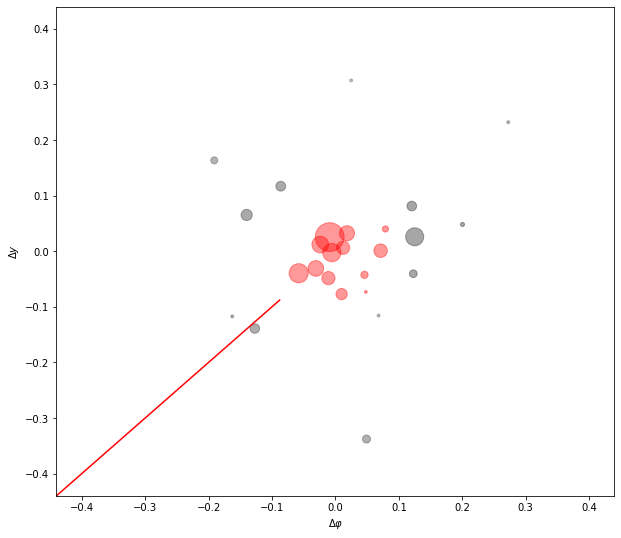

100.12067242446162 76.3638883003151 0.7627184921069085


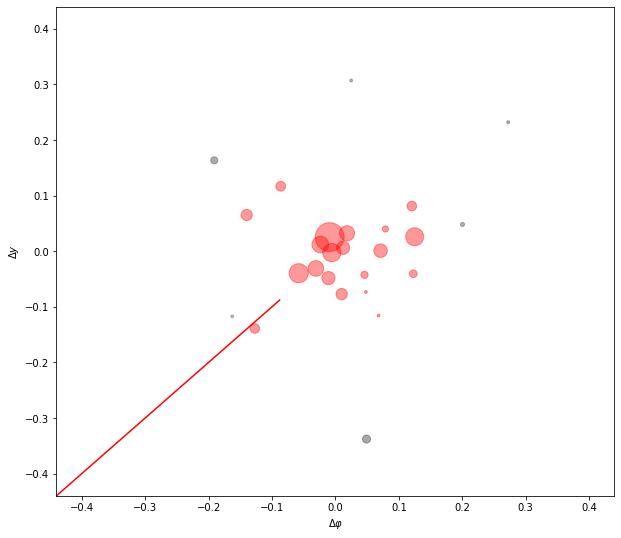

100.12067242446162 96.22516523112316 0.9610918794390088


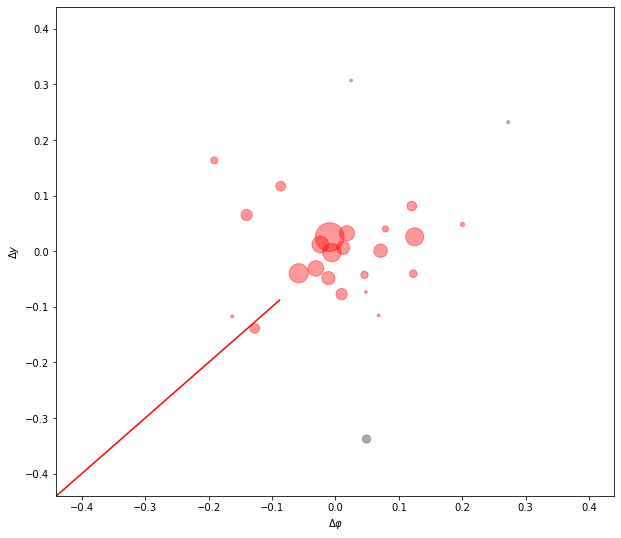

100.12067242446162 98.07469343793532 0.9795648697019097
 PYTHIA Error in SimpleSpaceShower::pT2nearThreshold: stuck in loop  


In [26]:
for n in range(1):
    j, subjets = next_event()
    # draw_jet(j)
    for sj_r in sj_rs:
        draw_subjets(j, j.perp()/4., sj_r)


In [15]:
pythia_hard.stat()


 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | g g -> g g                                     111 |        2494        137        137 |   5.873e+02  1.733e+01 |
 | g g -> q qbar (uds)                            112 |        

# voronoi diagrams
- consider adding the same but with the voronoi diagram marking (stop at R=jet_R0)